In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import sys
sys.path.append("/home/jovyan/PACEfun")
import helper
from dask.distributed import Client
import importlib, helper; importlib.reload(helper)


<module 'helper' from '/home/jovyan/PACEfun/helper.py'>

In [2]:
client = Client()
auth = earthaccess.login("login.netrc")


In [3]:
# --- TIME ---

tspan = ("2024-03-01 00:00", "2025-09-01 00:00")

# --- REGION ---

# 42.69174831596751, 21.058555012396997
region = (41.7, 20.36, 43.7, 22.06)
mid = (21.058555012396997, 42.69174831596751)
ext = 1.5
region = (mid[0] - ext , mid[1] - ext, mid[0] + ext, mid[1] + ext)
region


(19.558555012396997, 41.19174831596751, 22.558555012396997, 44.19174831596751)

In [4]:
results_spx = earthaccess.search_data(
    short_name="PACE_SPEXONE_L2_AER_RTAPLAND",
    cloud_hosted=True,
    bounding_box=region,
    temporal=tspan,
)
paths_spx = earthaccess.open(results_spx)


QUEUEING TASKS | :   0%|          | 0/123 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/123 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/123 [00:00<?, ?it/s]

In [5]:
wv = 550
wv_idx = helper.get_wv_idx(paths_spx[0], wv)
crs, shape_tmp, transform_tmp = helper.crs_template(paths_spx[0], "aot", wv)
# Select best data set who covers the most region for the study of interest
shape, transform, _ = helper.grid_aligned_subset(region, transform_tmp, shape_tmp)


In [6]:

kwargs = {"combine": "nested", "concat_dim": "time"}
attrs = xr.open_mfdataset(paths_spx, preprocess=helper.time_from_attr, **kwargs)
futures = client.map(
    helper.grid_match,
    paths_spx,
    dst_crs=crs,
    dst_shape=shape,
    dst_transform=transform,
    var="aot",
    wv_idx=wv_idx
)
da_spx_aod = xr.combine_nested(client.gather(futures), concat_dim="time")
da_spx_aod["time"] = attrs["time"]


kwargs_ae = {"combine": "nested", "concat_dim": "time"}
attrs_ae = xr.open_mfdataset(paths_spx, preprocess=helper.time_from_attr, **kwargs_ae)
futures_ae = client.map(
    helper.grid_match,
    paths_spx,
    dst_crs=crs,
    dst_shape=shape,
    dst_transform=transform,
    var="angstrom_440_670",
    wv_idx=None
)
da_spx_ae = xr.combine_nested(client.gather(futures_ae), concat_dim="time")
da_spx_ae["time"] = attrs_ae["time"]


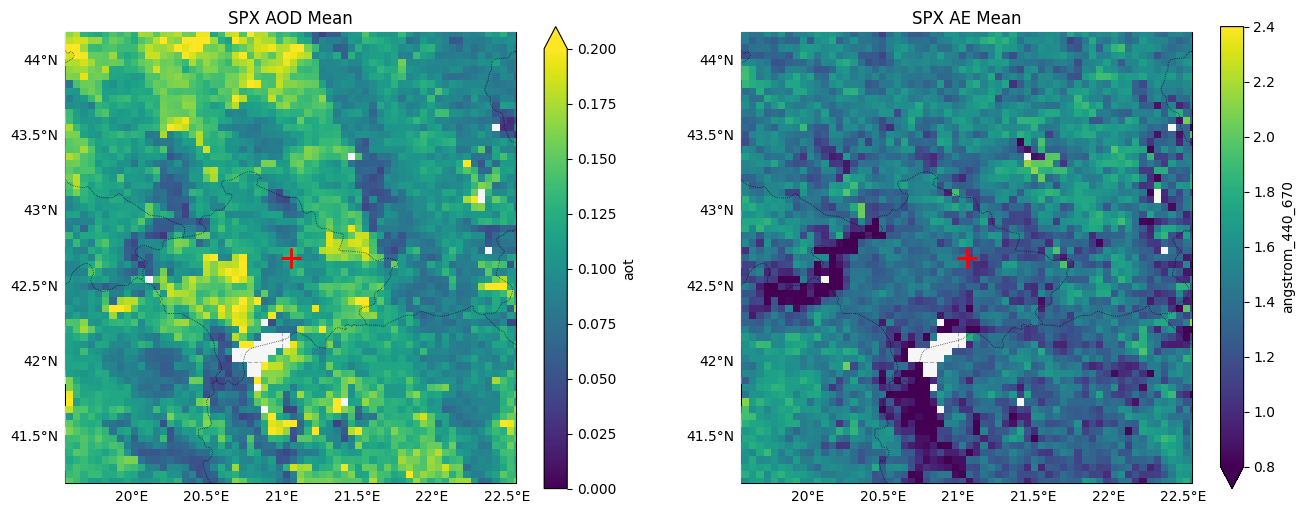

(<Figure size 1600x600 with 4 Axes>,
 [<GeoAxes: title={'center': 'SPX AOD Mean'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
  <GeoAxes: title={'center': 'SPX AE Mean'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>])

In [7]:
cross_lonlat = (21.058555012396997, 42.69174831596751)

# Static mean panel comparison using helper
helper.plot_mean_panels(
    [da_spx_aod, da_spx_ae],
    region=region,
    titles=["SPX AOD Mean", "SPX AE Mean"],
    crosshair=cross_lonlat,
    cmap="viridis",
    vmin=[0, 0.8],
    vmax=[0.2, 2.4],
    background=None,
    tiles_zoom=12,
)


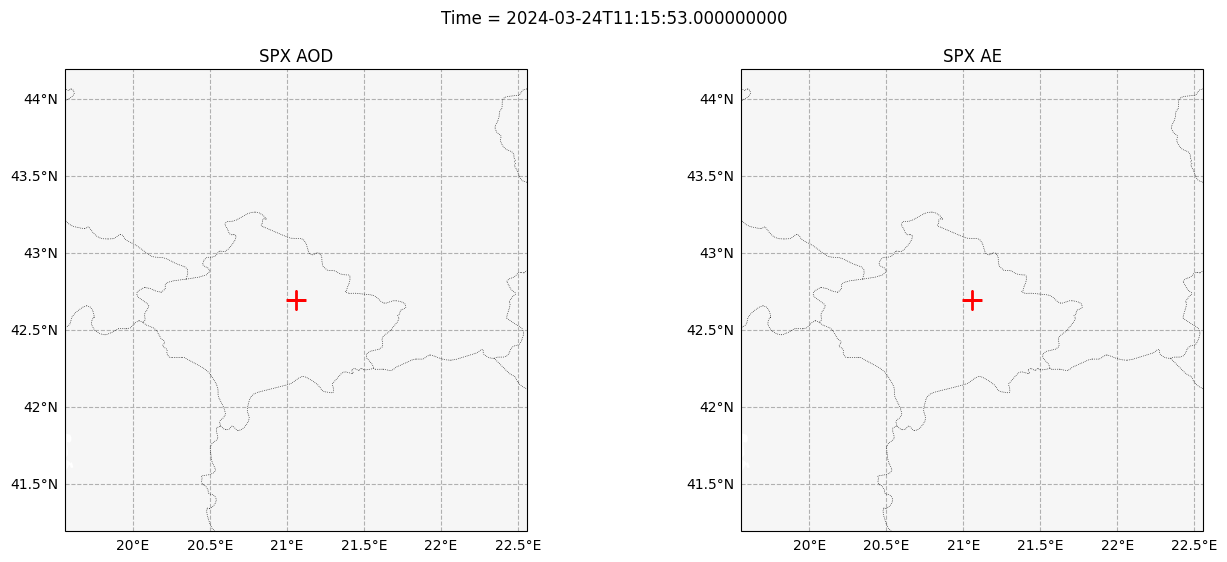

In [68]:
# Time animation using helper
_, _, ani = helper.animate_panels(
    [da_spx_aod, da_spx_ae],
    region=region,
    titles=["SPX AOD", "SPX AE"],
    crosshair=cross_lonlat,
    cmap="viridis",
    vmin=[0, 0.4],
    vmax=[0.6, 1.6],
    interval=600,
    save_path="PACEfun/movies/spx_oci_comparison.gif",
    writer="pillow",
    dpi=120,
)



In [12]:
# Interactive time slider (Jupyter) using helper
helper.interactive_panels(
    [da_spx_aod, da_spx_ae],
    region=region,
    titles=["SPX AOD Mean", "SPX AE Mean"],
    crosshair=cross_lonlat,
    vmin=[0, 0.4],
    vmax=[0.6, 2.4],
)


interactive(children=(IntSlider(value=0, description='i', max=122), Output()), _dom_classes=('widget-interact'…

<function helper.interactive_panels.<locals>.plot_frame(i)>

<function helper.interactive_panels.<locals>.plot_frame(i)>

In [70]:
transform[4]

-0.04807371919080367

In [8]:
def get_overme(da, lon, lat, method="nearest", tolerance=None):
    lon_res = transform[0]
    lat_res = transform[4]
    series = da.sel(longitude=lon, latitude=lat, method=method)
    mask = series.notnull()
    for scale in range(1,8):
        series = da.sel(longitude=lon+scale * lon_res, latitude=scale * lat, method=method)
        mask = series.notnull() | mask
        mask = series.notnull()
        series = da.sel(longitude=lon-lon_res, latitude=lat, method=method)
        mask = series.notnull() | mask
        series = da.sel(longitude=lon, latitude=lat+scale * lat_res, method=method)
        mask = series.notnull() | mask
        series = da.sel(longitude=lon, latitude=lat-scale * lat_res, method=method)
        mask = series.notnull() | mask
    mask_xr = xr.DataArray(mask.values, dims=["time"], coords={"time": da.time})
    da_masked = da.where(mask_xr, drop=True)
    return da_masked


da_spx_aod_filter = get_overme(da_spx_aod, *cross_lonlat)
da_spx_ae_filter = get_overme(da_spx_ae, *cross_lonlat)


In [9]:
helper.interactive_panels(
    [da_spx_aod_filter, da_spx_ae_filter],
    region=region,
    titles=["SPX AOD Mean", "SPX AE Mean"],
    crosshair=cross_lonlat,
    vmin=[0, 0.4],
    vmax=[0.6, 2.4],
)


interactive(children=(IntSlider(value=0, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

<function helper.interactive_panels.<locals>.plot_frame(i)>

<function helper.interactive_panels.<locals>.plot_frame(i)>